# 使用 di-PLS 进行域自适应
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___
首先，我们加载一些将要使用的模块，包括 di-PLS 类。

In [2]:
# 加载模块
import numpy as np
import matplotlib.pyplot as plt
from diPLSlib.models import DIPLS as dipls
from diPLSlib.utils import misc as fct

# 配置中文绑图支持
fct.setup_chinese_plot()

### 数据集

让我们创建一些模拟的“源域”和“目标域”数据集，分别包含 N=50 个样本和 p=100 个变量。

In [3]:
n = 50  # 样本数量
p = 100 # 变量数量

为此，我们定义了 3 个高斯函数，其中第一个对应于我们将尝试建模的（分析物）信号，另外两个对应于干扰信号（干扰物）。

源域数据集将仅包含分析物信息以及两个干扰物中**一个**的贡献。

In [4]:
np.random.seed(10)

# 源域 (分析物 + 1 种干扰物)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # 分析物信号
S2 = fct.gengaus(p, 70, 10, 10, 0) # 干扰物 1 信号
S = np.vstack([S1,S2])

# 分析物和干扰物浓度
Cs = 10*np.random.rand(n,2)

# 光谱
Xs = Cs@S

在目标域中，我们将有来自分析物和**两种**干扰物的贡献。

In [5]:
# 目标域 (分析物 + 2 种干扰物)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # 分析物信号
S2 = fct.gengaus(p, 70, 10, 10, 0) # 干扰物 1 信号
S3 = fct.gengaus(p, 30, 10, 10, 0) # 干扰物 2 信号
S = np.vstack([S1,S2,S3])

# 分析物和干扰物浓度
Ct = 10*np.random.rand(n,3)

# 光谱
Xt = Ct@S

让我们绘制分析物和干扰物的纯信号以及模拟数据集。

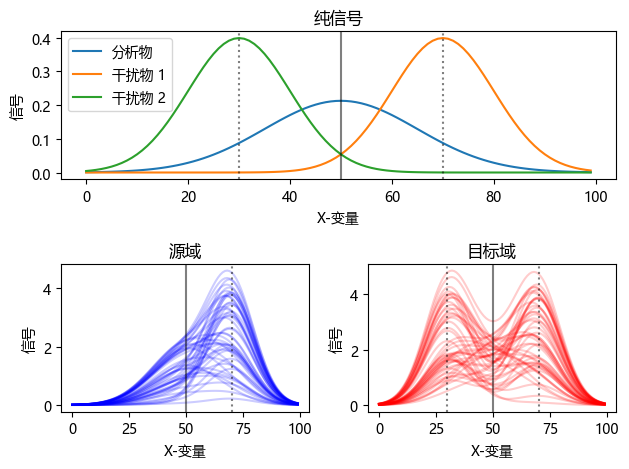

In [6]:
# 绘制纯信号
plt.figure()

plt.subplot(211)
plt.plot(S1)
plt.plot(S2)
plt.plot(S3)
plt.legend(['分析物','干扰物 1','干扰物 2'])
plt.title('纯信号')
plt.xlabel('X-变量')
plt.ylabel('信号')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)

# 源域
plt.subplot(223)
plt.plot(Xs.T, 'b', alpha=0.2)
plt.title('源域')
plt.xlabel('X-变量')
plt.ylabel('信号')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)

# 目标域
plt.subplot(224)
plt.plot(Xt.T, 'r', alpha=0.2)
plt.title('目标域')
plt.xlabel('X-变量')
plt.ylabel('信号')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.tight_layout()

### 偏最小二乘回归 (PLS)
我们现在将尝试在给定模拟光谱的情况下对源域中的分析物浓度进行建模，并使用标准 PLS 将模型应用于目标域。

Text(0.5, 1.0, '标准 PLS')

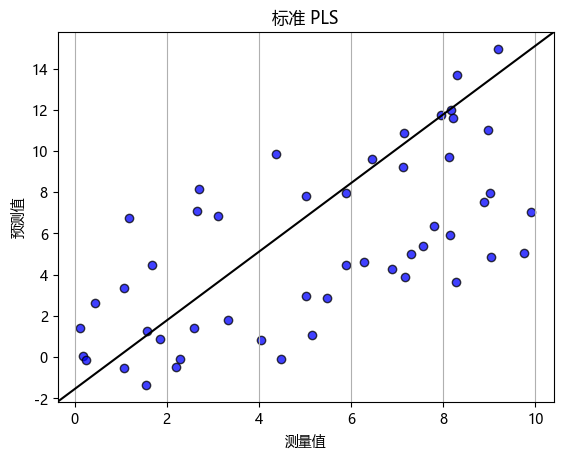

In [7]:
# 源域 PLS 模型 (2 LVs)
y = np.expand_dims(Cs[:, 0],1)
m = dipls(A=2, l=0)
l = [0] # 无正则化
m.fit(Xs, y, Xs, Xt)
b_source = m.b_

# 预测目标域中的分析物
yhat_pls = m.predict(Xt)

# 绘制测量与预测的分析物浓度
plt.scatter(Ct[:, 0], yhat_pls, color='b', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('测量值')
plt.ylabel('预测值')
plt.grid(axis='x')
plt.title('标准 PLS')

正如预期的那样，源域模型的预测在应用于目标域时不是很准确，因为后者包含来自额外干扰物的贡献。

### 域不变偏最小二乘 (di-PLS)
我们现在将包含目标域数据（没有相应的分析物浓度），并添加一些域正则化以解释目标域中的额外干扰。

Text(0.5, 1.0, 'di-PLS')

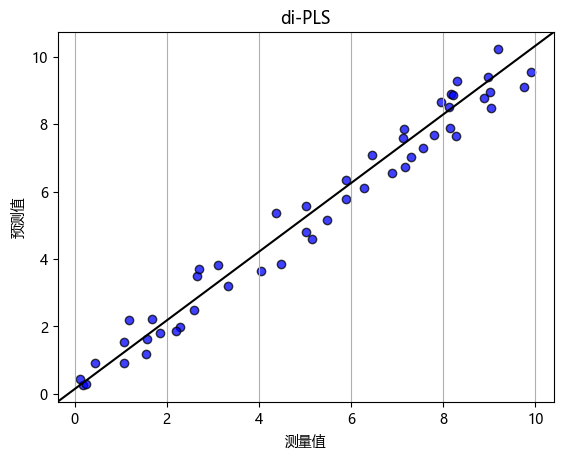

In [8]:
# di-PLS 模型 (2 LVs)
y = np.expand_dims(Cs[:, 0],1)
m2 = dipls(A=2, l=1000, rescale='Target')
m2.fit(Xs, y, Xs, Xt)
b_inv = m2.b_

# 预测目标域中的分析物
yhat_dipls = m2.predict(Xt)

# 绘制测量与预测的分析物浓度
plt.scatter(Ct[:, 0], yhat_dipls, color='b', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('测量值')
plt.ylabel('预测值')
plt.grid(axis='x')
plt.title('di-PLS')

该模型现在能以高精度预测目标域中的分析物浓度！请注意，我们仅包含了目标域的 X 数据而没有 Y 数据（连同源域的 X 和 Y 数据），就找到了适用于目标域（以及源域！）的良好模型。这在文献中有时被称为“无监督域自适应”。

让我们试着理解 di-PLS 如何改进目标域的预测。为此，我们将查看源域和目标域数据在 PLS 和 di-PLS 模型所涵盖的潜变量 (LV) 空间上的投影。

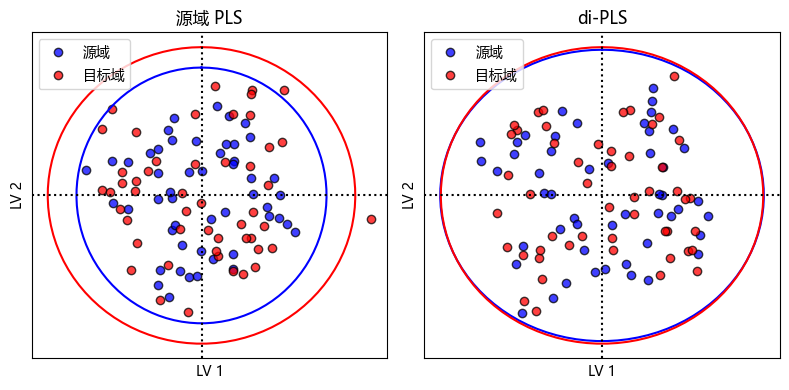

In [9]:
plt.figure(figsize=(8,4))

# PLS 投影 (得分)
plt.subplot(1,2,1)
m = dipls(A=2, l=0, rescale='Target')
m.fit(Xs, y, Xs, Xt)
plt.plot(m.Ts_[:, 0], m.Ts_[:, 1], 'ob', mec='k', 
alpha=0.75)
plt.plot(m.Tt_[:, 0], m.Tt_[:, 1], 'or', mec='k', alpha=0.75)
plt.legend(['源域', '目标域'], loc=2)
el_source = fct.hellipse(m.Ts_)
el_target = fct.hellipse(m.Tt_)
plt.plot(el_source[0,:],el_source[1,:],'b')
plt.plot(el_target[0,:],el_target[1,:],'r')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.axhline(y=0,color='k',linestyle=':')
plt.axvline(x=0,color='k',linestyle=':')
plt.title('源域 PLS')
plt.xlabel('LV 1')
plt.ylabel('LV 2')

# di-PLS 得分
plt.subplot(1,2,2)
m = dipls(A=2, l=10000, rescale='Target')
m.fit(Xs, y, Xs, Xt)
plt.plot(m.Ts_[:, 0], m.Ts_[:, 1], 'ob', mec='k', 
alpha=0.75)
plt.plot(m.Tt_[:, 0], m.Tt_[:, 1], 'or', mec='k', alpha=0.75)
plt.legend(['源域', '目标域'], loc=2)
el_source = fct.hellipse(m.Ts_)
el_target = fct.hellipse(m.Tt_)
plt.plot(el_source[0,:],el_source[1,:],'b')
plt.plot(el_target[0,:],el_target[1,:],'r')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.axhline(y=0,color='k',linestyle=':')
plt.axvline(x=0,color='k',linestyle=':')
plt.title('di-PLS')
plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.tight_layout()

从这两个图中可以看出，源域和目标域得分（即在 LV 空间上的投影）的分布在 di-PLS 模型中对齐得更好。在源域中使用得分投影看起来“就像是从相同的底层分布中采样的一样”的 LV 对分析物进行建模，可以提高跨域的泛化能力。这直接遵循了“不同域学习理论”（Ben-David 等人，Mach. Learn. 2010）。

现在让我们看看 PLS 和 di-PLS 模型的回归系数。

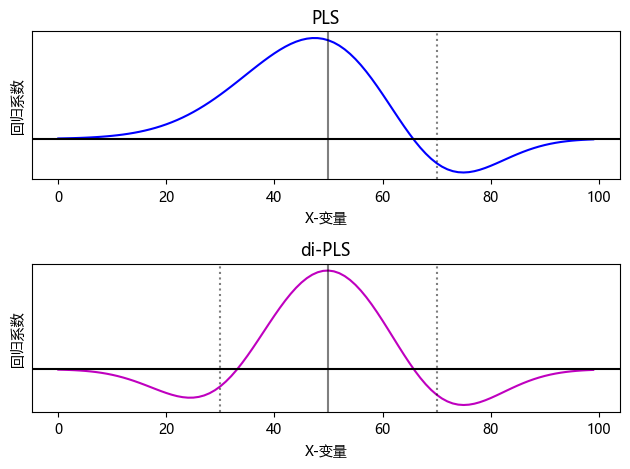

In [10]:
# PLS 回归系数
plt.subplot(2,1,1)
plt.plot(b_source, 'b')
plt.axhline(y=0, linestyle='-',color='k')
plt.ylabel('回归系数')
plt.xlabel('X-变量')
plt.tick_params(labelleft=False, left=False)
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.title('PLS')

# di-PLS 回归系数
plt.subplot(2,1,2)
plt.plot(b_inv, 'm')
plt.axhline(y=0, linestyle='-',color='k')
plt.ylabel('回归系数')
plt.xlabel('X-变量')
plt.tick_params(labelleft=False, left=False)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.title('di-PLS')
plt.tight_layout()

可以看出，PLS 模型“补偿”了信号在 X=70 处具有最大值的第一个干扰物（虚线）。此外，di-PLS 模型还补偿了第二个干扰物（信号在 X=30 处最大），这解释了为什么后者能更好地泛化到目标域。